In [1]:
%matplotlib inline


# Bonus: Affine and AI
teacher notebook





### our image backbone libraries

In [2]:
#import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
from skimage import data, io, color, img_as_float, exposure

### libraries generally good to have around

In [3]:
import os
import glob
import numpy as np
#import ipywidgets as widgets
import sys


# skimage time

In [4]:

from skimage import data
from skimage import transform
from skimage import img_as_float
from skimage.transform import rotate
#from skimage.transform import AffineTransform
from skimage import transform as tf

## Our images

In [5]:
image_b = io.imread('cardiomegaly_cc0.png') # cardiomegaly CXR
image_g = io.imread('rotatechest.png') # a relatively normal CXR
image_y = io.imread('other_op.png') # a relatively normal CXR


### Let's examine the  images

## Let's look at some non-geometric transformations

C:\Users\makeda\anaconda3\envs\image_libraries\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
C:\Users\makeda\AppData\Local\Temp\ipykernel_7124\1917060308.py:50: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\makeda\anaconda3\envs\image_libraries\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on 

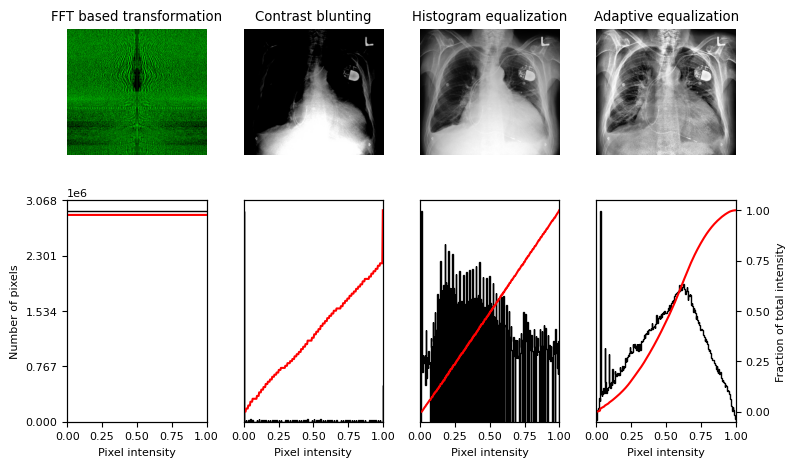

In [6]:
matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist,  ax_cdf


# Load an example image
img = image_b

# Make an FFT trasnform

made_fourier = np.fft.fftshift(np.fft.fft2(image_b))

# Contrast blunting
p60, p90 = np.percentile(img, (60, 90))
img_rescale = exposure.rescale_intensity(img, in_range=(p60, p90))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(made_fourier[::1].real, axes[:, 0])
ax_img.set_title('FFT based transformation')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast blunting')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()



## Now let's get into geometric transformations

NB: rescale, resize etc. are geometric transformations, but so are all affines, which can be rotates or shears

Geometrical transformations involve multiplying our image matrix by another. 
NB: there is always a matrix that will not change ours, the identity matrix.

# Your task

An affine transformation is a transform that is one or  any combination of the following:

    Shifting
    Scaling
    Flipping over any axis
    Rotating
    Shearing



You have been assigned to make an algorithm for cardiomegaly detection so patients can be notified if by change their X-ray shows cardiomegaly. You are given a dataset of healthy (no cardiomegaly) patients who went to an outpatient clinic  in a poor area staffed with first year radiography students and Xrays of cardiomegaly patients from a prestigeous hospital. 

Text(0.5, 1.0, 'Normal 2')

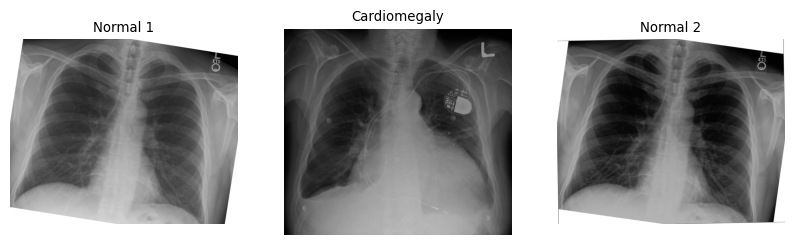

In [7]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(image_g)
plt.axis('off')
plt.title("Normal 1")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Cardiomegaly")

# Adds a subplot at the 3nd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(image_y)
plt.axis('off')
plt.title("Normal 2")


You want to make a dataset of realistic upright chest X-rays from two images to generate a propsed pipeline for preprocessing. Your question is about the label of cardiomegaly, i.e. big hearts. Use skimage.tranform.rotate to produce two realistic augmented images  (name them new_pic1 and new_pic2) from the given 'normal' image, and then apply what you percieve as the two most critical algorithms to make them ready for classic supervised machine learning in one bit of code. (hint: look at the shape of the cardiomegaly image in more ways than one)

 skimage.transform.AffineTransform(matrix=None, scale=None, rotation=None, shear=None, translation=None, *, dimensionality=2)

In [9]:
# code students need to add
new_pic1 = rotate(image_g, -2)
new_pic2 = rotate(image_g, 2)



Text(0.5, 1.0, 'Augment 2')

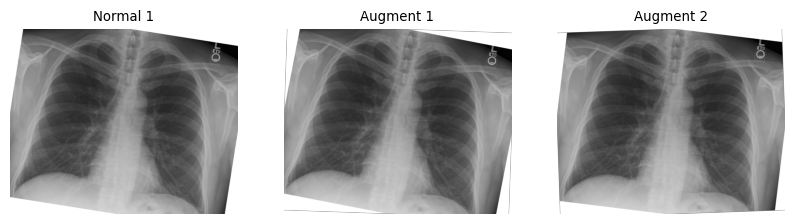

In [10]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(image_g)
plt.axis('off')
plt.title("Normal 1")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(new_pic1)
plt.axis('off')
plt.title("Augment 1")

# Adds a subplot at the 3nd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(new_pic2)
plt.axis('off')
plt.title("Augment 2")

In [12]:
# Potential extra algorithm 1 = shaving- otherwise the border is a strong line and obvious clue, and size normalize

In [13]:
# figure out how much to cut on sides
print("cut top/bottom:", (image_b.shape[0] - image_g.shape[0])/2)

# figure our how much to cut on top and bottom
print("cut sides:",(image_b.shape[1] - image_g.shape[1])/2)

cut top/bottom: -119.0
cut sides: -208.5


In [14]:
list_images = [image_g, new_pic1, new_pic2]

In [15]:
better_for_ml_list = []
for image in list_images:
    image = image[119:-119, 208: -209]
    better_for_ml_list.append(image)


Text(0.5, 1.0, 'Augment 2')

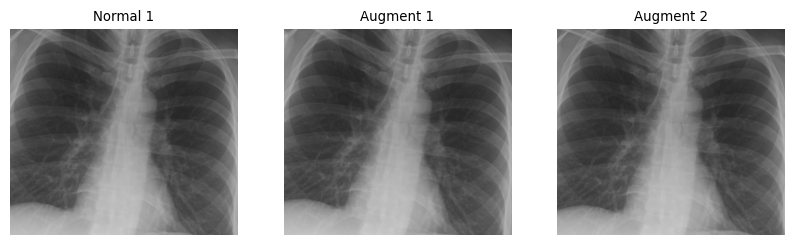

In [16]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(better_for_ml_list[0])
plt.axis('off')
plt.title("Normal 1")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(better_for_ml_list[1])
plt.axis('off')
plt.title("Augment 1")

# Adds a subplot at the 3nd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(better_for_ml_list[2])
plt.axis('off')
plt.title("Augment 2")

skimage.transform.warp(image, inverse_map, map_args={}, output_shape=None, order=None, mode='constant', cval=0.0, clip=True, preserve_range=False

warp will warp an image according to a given coordinate transformation.

In [17]:
## Now you want to add to your data with a sheared version of the cardiomegaly image
# shearing like all of these operations is a matrix multiplication, you will need to create the matrix, then let the program do some math

# use AffineTransform() class to create a shearing matrix to do this, see documentation (https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.AffineTransform) 

# then show the matrix by just putting it in the cell

# then use tf.warp to apply  the matrix and 'magical' math

# finally display the output (your sheared image)

In [18]:
# Create Afine transform
afine_tf = tf.AffineTransform(shear=0.2)

afine_tf

<AffineTransform(matrix=
    [[ 1.        , -0.19866933,  0.        ],
     [ 0.        ,  0.98006658,  0.        ],
     [ 0.        ,  0.        ,  1.        ]]) at 0x1cdc1d15e80>

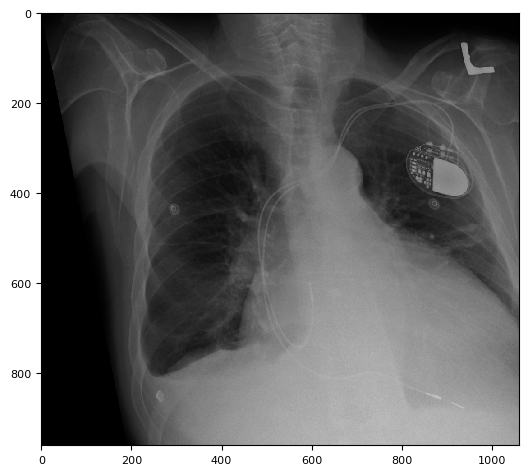

In [19]:
# Apply transform to image data
modified = tf.warp(image_b, inverse_map=afine_tf)

# Display the result
io.imshow(modified)
io.show()

In [20]:


# Cheat documentation (https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html#sphx-glr-auto-examples-transform-plot-transform-types-py)